Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


455/455 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6680 - loss: 0.7665 - val_accuracy: 0.7252 - val_loss: 0.9526
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6838 - loss: 0.6217 - val_accuracy: 0.7228 - val_loss: 0.8545
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7238 - loss: 0.4866 - val_accuracy: 0.6812 - val_loss: 0.8571
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7803 - loss: 0.3690 - val_accuracy: 0.7052 - val_loss: 0.8039
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8425 - loss: 0.2700 - val_accuracy: 0.6183 - val_loss: 0.9996
Epoch 6/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8912 - loss: 0.1849 - val_accuracy: 0.7324 - val_loss: 0.9235
Epoch 7/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9303 - loss: 0.1126 - val_accuracy: 0.7252 - val_loss: 1.0024
Epoch 8/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9507 - loss: 0.0801 - val_accuracy: 0.728

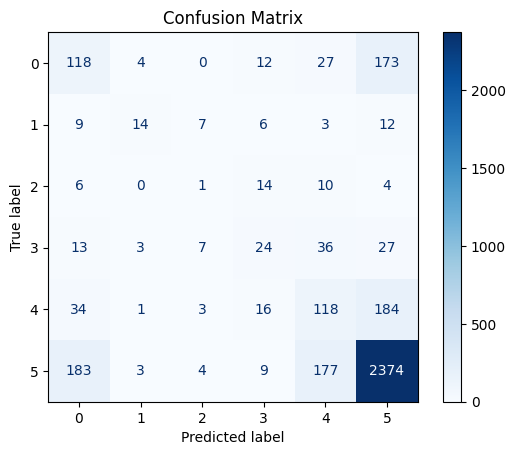


Accuracy: 0.7285
Precision (macro): 0.4001
Recall (macro): 0.3449

Classification Report:
              precision    recall  f1-score   support

           0     0.3251    0.3533    0.3386       334
           1     0.5600    0.2745    0.3684        51
           2     0.0455    0.0286    0.0351        35
           3     0.2963    0.2182    0.2513       110
           4     0.3181    0.3315    0.3246       356
           5     0.8558    0.8633    0.8595      2750

    accuracy                         0.7285      3636
   macro avg     0.4001    0.3449    0.3629      3636
weighted avg     0.7255    0.7285    0.7261      3636



In [1]:
# class_weight soft and epochs = 10

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

df = pd.read_csv("Recipe Reviews and User Feedback Dataset.csv")
columns_to_drop = [
    'recipe_number', 'recipe_code', 'recipe_name',
    'comment_id', 'user_id', 'user_name', 'created_at'
]
df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned = df_cleaned.dropna(subset=['text'])

texts = df_cleaned['text'].astype(str).values
labels = df_cleaned['stars'].values
numeric_features = df_cleaned[['user_reputation', 'reply_count', 'thumbs_up', 'thumbs_down', 'best_score']]

scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)

MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
text_padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    text_padded, numeric_features_scaled, labels, test_size=0.2, random_state=42)

num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_soft = np.log1p(class_weights)  
class_weights = dict(enumerate(class_weights_soft))

text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')
x = Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH)(text_input)
x = Conv1D(filters=128, kernel_size=5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

numeric_input = Input(shape=(X_num_train.shape[1],), name='numeric_input')
y = Dense(64, activation='relu')(numeric_input)

combined = Concatenate()([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(num_classes, activation='softmax')(z)

model = Model(inputs=[text_input, numeric_input], outputs=z)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    [X_text_train, X_num_train], y_train_cat,
    validation_data=([X_text_test, X_num_test], y_test_cat),
    epochs=10,
    batch_size=32,
    class_weight=class_weights
)

y_pred_probs = model.predict([X_text_test, X_num_test])
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

precision = precision_score(y_true, y_pred, average='macro')
print(f"Precision (macro): {precision:.4f}")

recall = recall_score(y_true, y_pred, average='macro')
print(f"Recall (macro): {recall:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))